# Psuedobulk creation with decoupler
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook performs a

# Set-up

In [5]:
# Global Imports
import os
import sys
import yaml
import random
import time
import datetime
import logging
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

# Local imports
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

In [25]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"

# Inputs
platinum_dir = "/cellar/users/aklie/data/igvf/beta_cell_networks/platinum"
in_date = "25Aug23"
in_dir = os.path.join(platinum_dir, dataset_name, in_date, "scRNA")

# Outputs
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome"
out_date = "25Aug23"
out_analysis = "create_pseudobulks"
out_dir = os.path.join(results_dir, out_date, "pseudobulk_analysis", out_analysis)

# Make and log a yaml file with the parameters
time_id = time.strftime("%Y%m%d-%H%M%S")
run_id =  random.getrandbits(32)
run = str(run_id) + "_" + time_id
out_dir = os.path.join(out_dir, run)
make_dirs(out_dir)

# Method params
pb_min_cells = 10
pb_min_counts = 1000
pb_mode = "sum"

In [26]:
data_params = {
    "dataset_name": dataset_name,
    "results_dir": results_dir,
    "in_date": in_date,
    "in_dir": in_dir,
    "out_date": out_date,
    "out_analysis": out_analysis,
    "out_dir": out_dir,
}
method_params = {
    "pb_min_cells": pb_min_cells,
    "pb_min_counts": pb_min_counts,
    "pb_mode": pb_mode,
}
version_params = {
    "time_id": time_id,
    "run_id": run_id,
    "Python": sys.version[:5],
    "Scanpy": sc.__version__,
    "decoupler": dc.__version__,
}
params = {"data": data_params, "run": method_params, "versions": version_params}
params_file = os.path.join(out_dir,"pseudobulk_creation_params.yaml")
if not os.path.exists(os.path.join(out_dir, params_file)):
    with open(os.path.join(out_dir, params_file), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load data

In [9]:
# The data to load in formatted as a 10x directory, change if you have a different format for reading in data
adata = sc.read_10x_mtx(in_dir, cache=True)

... reading from cache file cache/cellar-users-aklie-data-igvf-beta_cell_networks-platinum-igvf_sc-islet_10X-Multiome-25Aug23-scRNA-matrix.h5ad


In [10]:
# Metadata to add, may or may not be necessary depending on the adata
metadata = pd.read_csv(os.path.join(in_dir, "metadata.csv"), index_col=0, low_memory=False)

In [11]:
# Add metadata to adata
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)

In [12]:
# Print all the dim reduction files
reduce_dir = "/cellar/users/aklie/data/igvf/beta_cell_networks/barcode_metadata/igvf_sc-islet_10X-Multiome/10Aug23/reductions"
reductions = os.listdir(reduce_dir)
reductions

['sct.harmony.tsv',
 'lsi.tsv',
 'harmony.tsv',
 'pca.tsv',
 'atac.harmony.tsv',
 'umap.wnn.tsv']

In [13]:
# Add all the reduction files
reduce_names = []
for reduction in reductions:
    reduction_mat = pd.read_csv(os.path.join(reduce_dir, reduction), index_col=0, sep="\t")
    reduction = reduction.split(".tsv")[0].replace(".", "_")
    reduce_name = f"Seurat_{reduction}"
    adata.obsm[reduce_name] = reduction_mat.values
    reduce_names.append(reduce_name)
adata.obsm

AxisArrays with keys: Seurat_sct_harmony, Seurat_lsi, Seurat_harmony, Seurat_pca, Seurat_atac_harmony, Seurat_umap_wnn

In [14]:
# Clean up
adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype("category")
adata.obs["time_point"] = adata.obs["time_point"].astype("category")
adata.obs["predicted_cell_type"] = adata.obs["predicted.cell.type"].str.replace(".", "_")

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


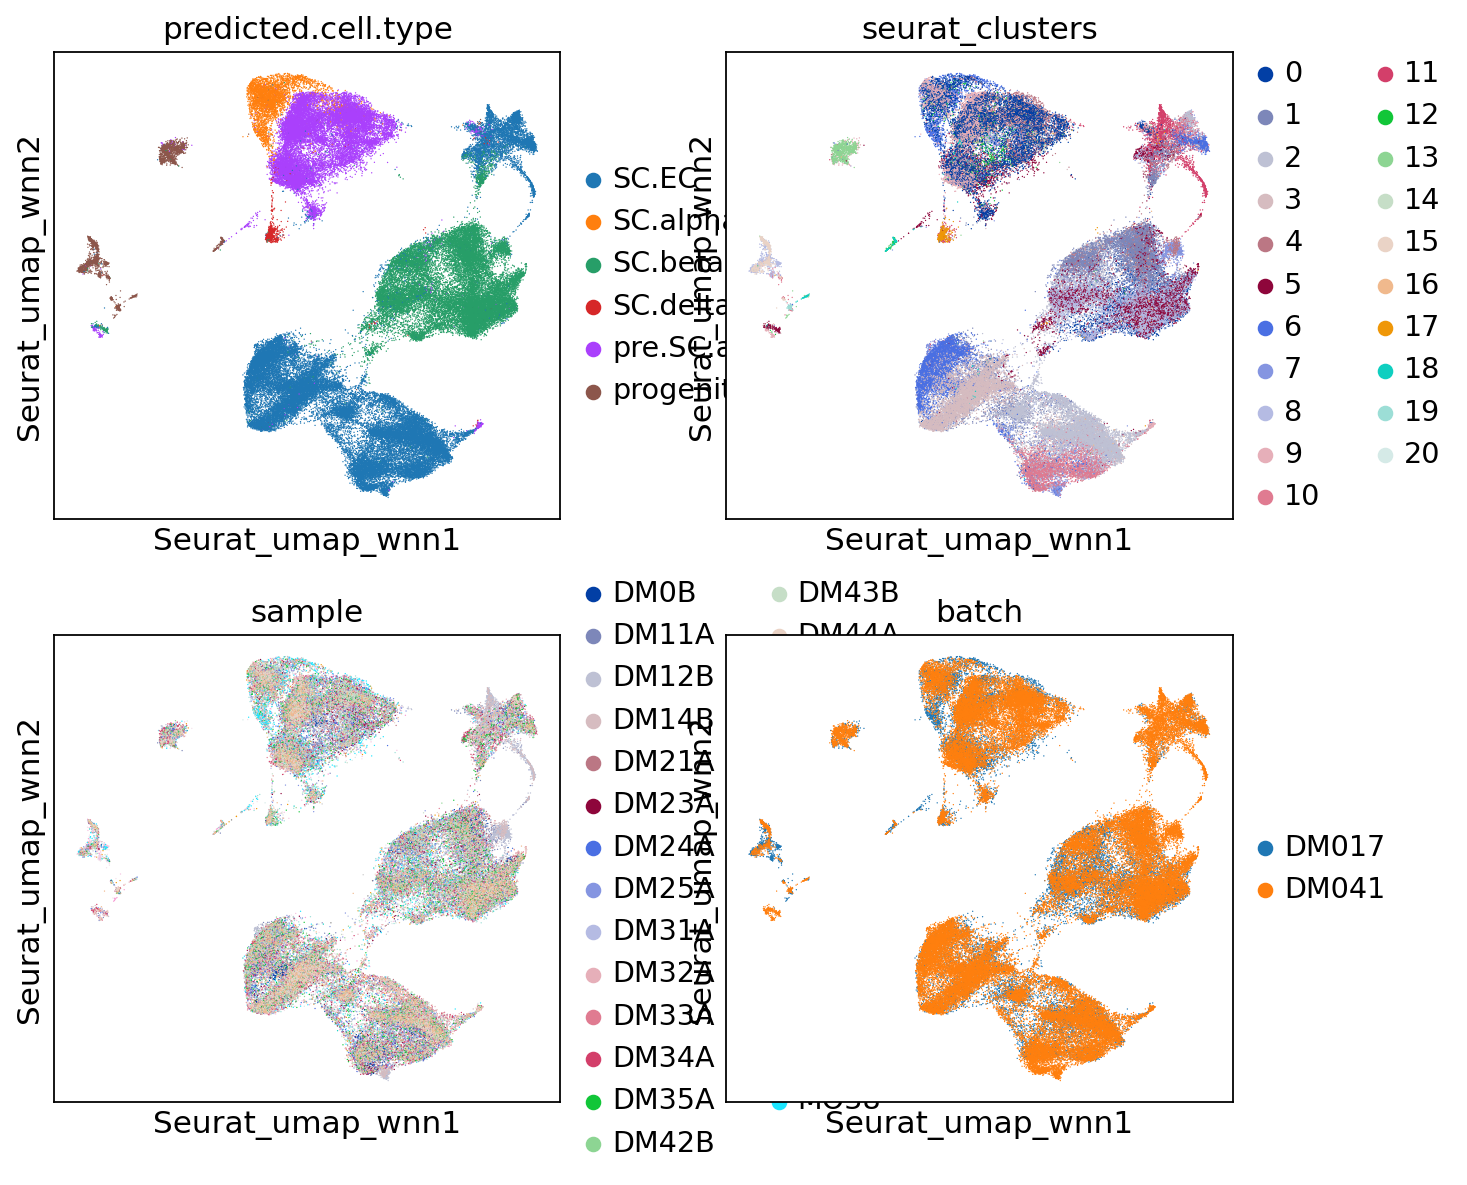

In [15]:
# Check the adata object
with plt.rc_context():
    sc.pl.embedding(adata, basis='Seurat_umap_wnn', color=['predicted.cell.type', 'seurat_clusters', 'sample', 'batch'], ncols=2, show=False)
    plt.savefig(os.path.join(out_dir, "starting_adata.png"), bbox_inches='tight', dpi=300)
    plt.show()

In [18]:
# Verify that this is counts data
test_data = adata.X[:10, :10].todense()
if np.all(test_data >= 0) and np.all(test_data.astype(int) == test_data):
    print("The matrix contains count data.")
else:
    print("The matrix does not contain count data.")

The matrix contains count data.


# Preprocess data

In [19]:
# Basic filtering of genes and cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 4355 genes that are detected in less than 3 cells


In [20]:
# Store raw counts in layers
adata.layers['counts'] = adata.X.copy()

In [21]:
# Verify that this is counts data
test_data = adata.layers["counts"][:10, :10].todense()
if np.all(test_data >= 0) and np.all(test_data.astype(int) == test_data):
    print("The matrix contains count data.")
else:
    print("The matrix does not contain count data.")

The matrix contains count data.


# Pseudobulk profiles

In [27]:
# Create a dir for the pseudobulk h5ads
make_dirs(os.path.join(out_dir, "pseudobulk_h5ads"))

'/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome/25Aug23/pseudobulk_analysis/create_pseudobulks/2545199730_20230829-095741/pseudobulk_h5ads'

In [22]:
# Get pseudo-bulk profile without any filtering
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample',
    groups_col='predicted.cell.type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata

AnnData object with n_obs × n_vars = 162 × 32246
    obs: 'orig.ident', 'batch', 'condition', 'time_point', 'sample', 'predicted.cell.type', 'predicted_cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'psbulk_props'

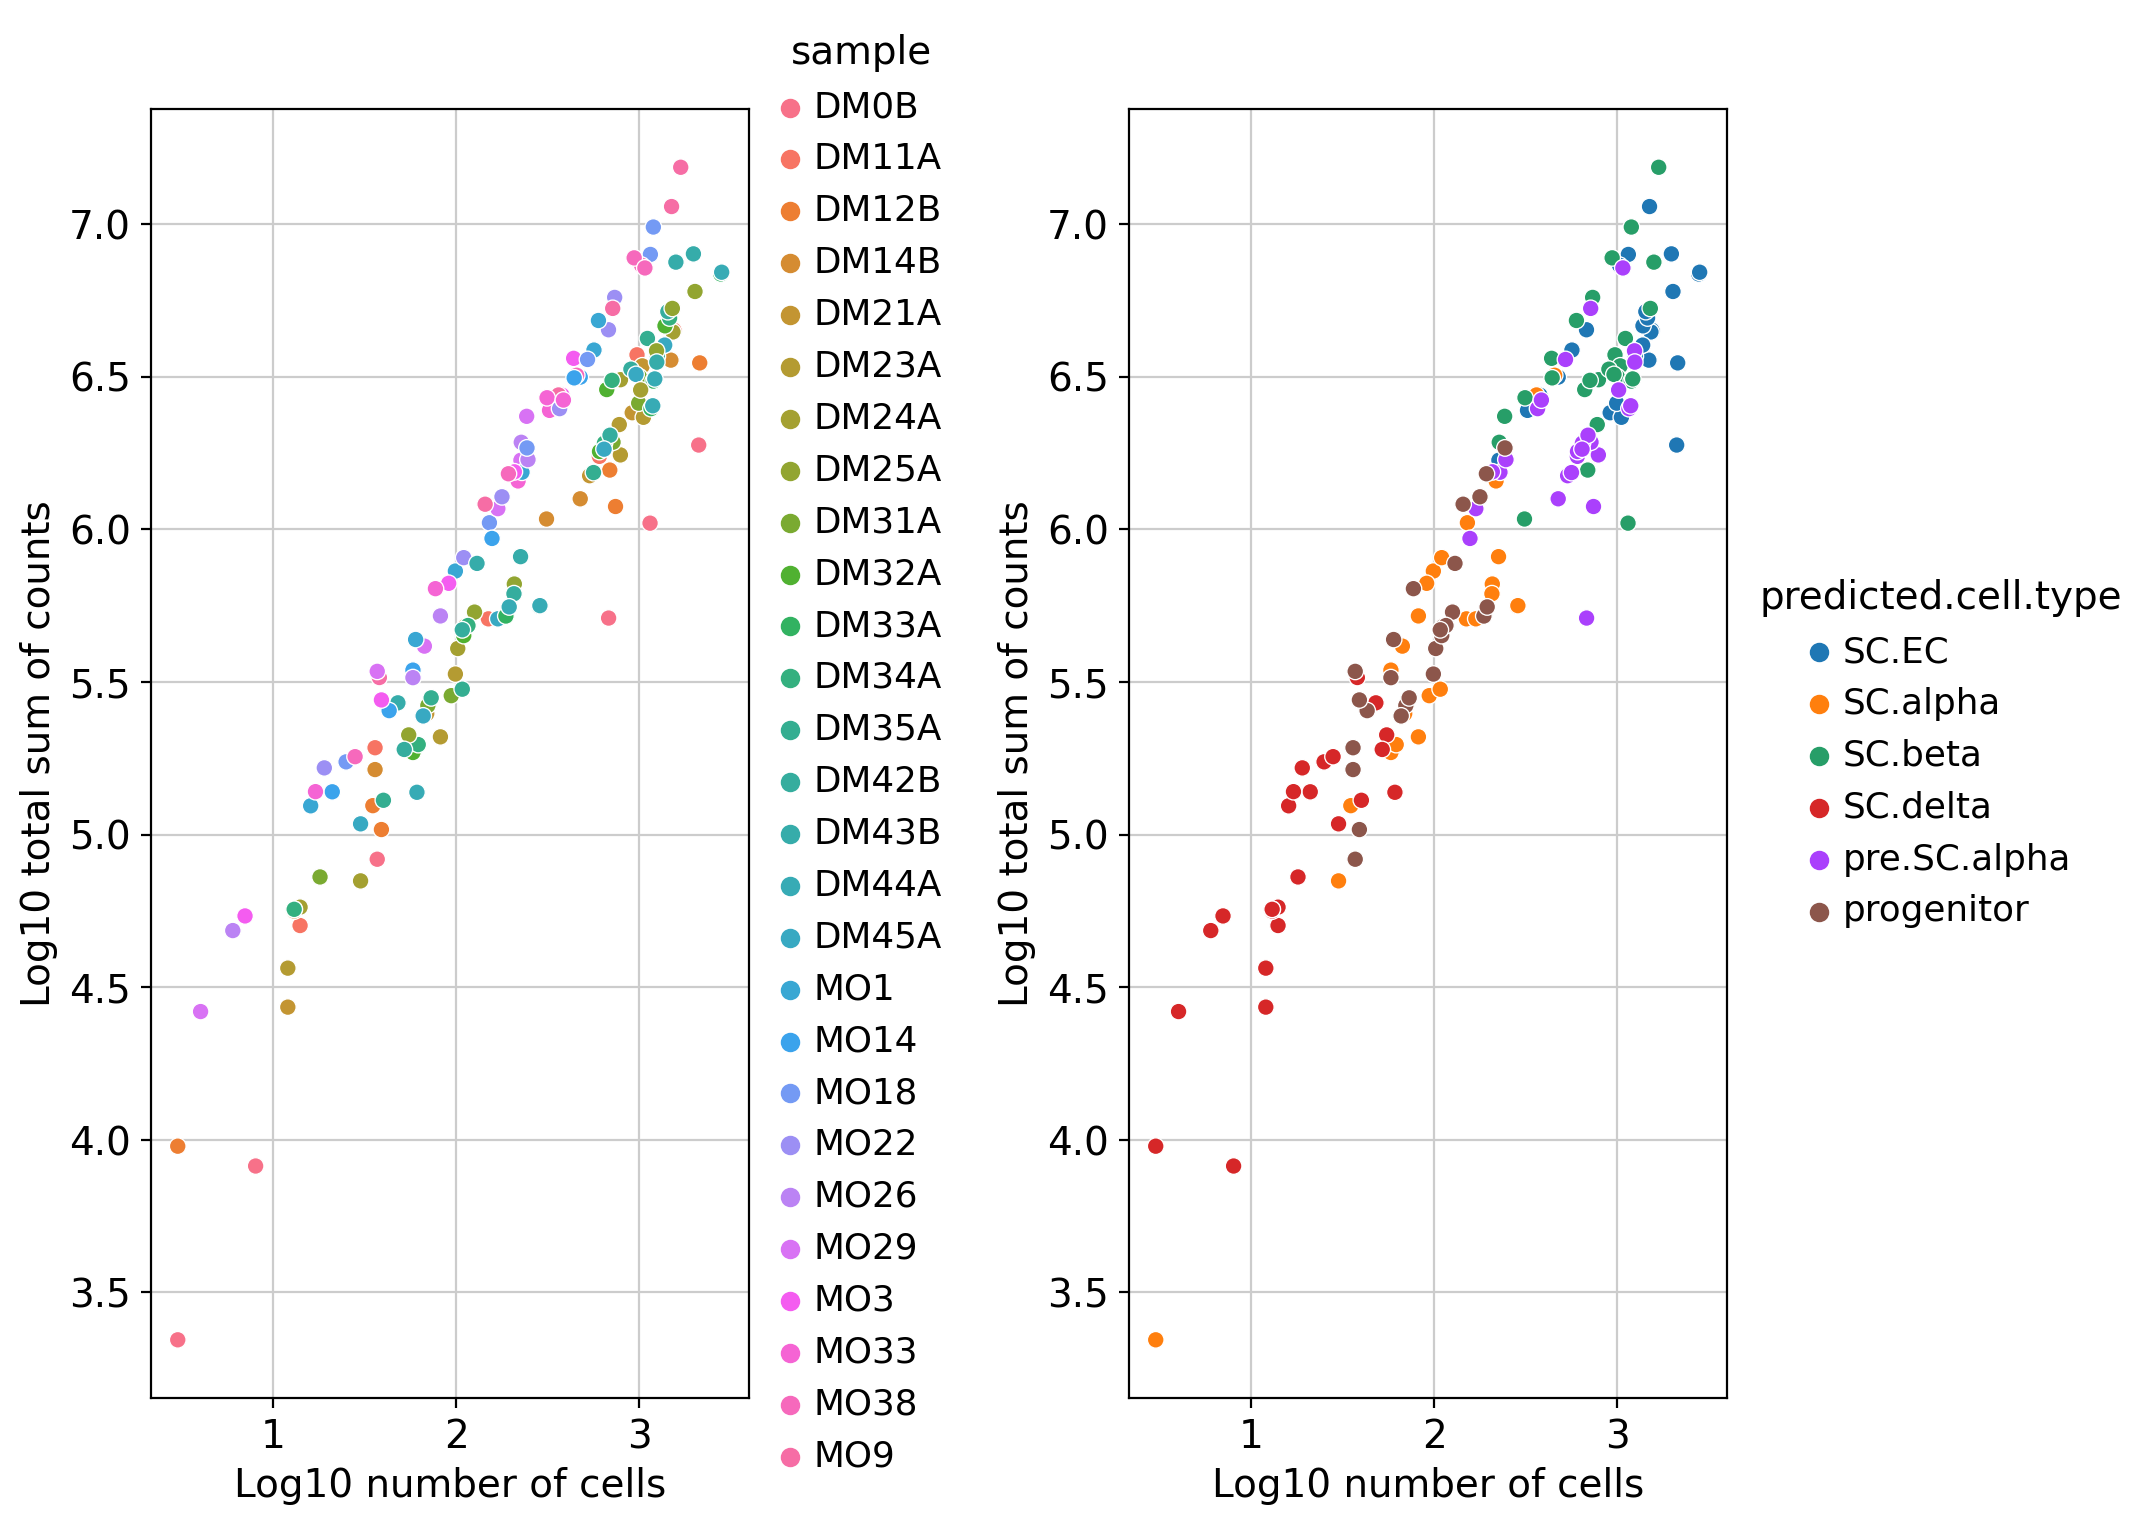

In [28]:
# Plot some QCs on the pseudo-bulk data
dc.plot_psbulk_samples(pdata, groupby=['sample', 'predicted.cell.type'], figsize=(11, 8), save=os.path.join(out_dir, "psbulk_samples_plot.png"))

In [29]:
# Save just the normal pseudo-bulk
pdata.obs["time_point"] = pdata.obs["time_point"].astype("category")
pdata.write(os.path.join(out_dir, "pseudobulk_h5ads", "pseudo_bulk_no_filter.h5ad"))

In [30]:
# Get pseudo-bulk profile without any filtering
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample',
    groups_col='predicted.cell.type',
    layer='counts',
    mode=pb_mode,
    min_cells=pb_min_cells,
    min_counts=pb_min_counts
)
pdata

AnnData object with n_obs × n_vars = 156 × 32246
    obs: 'orig.ident', 'batch', 'condition', 'time_point', 'sample', 'predicted.cell.type', 'predicted_cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'psbulk_props'

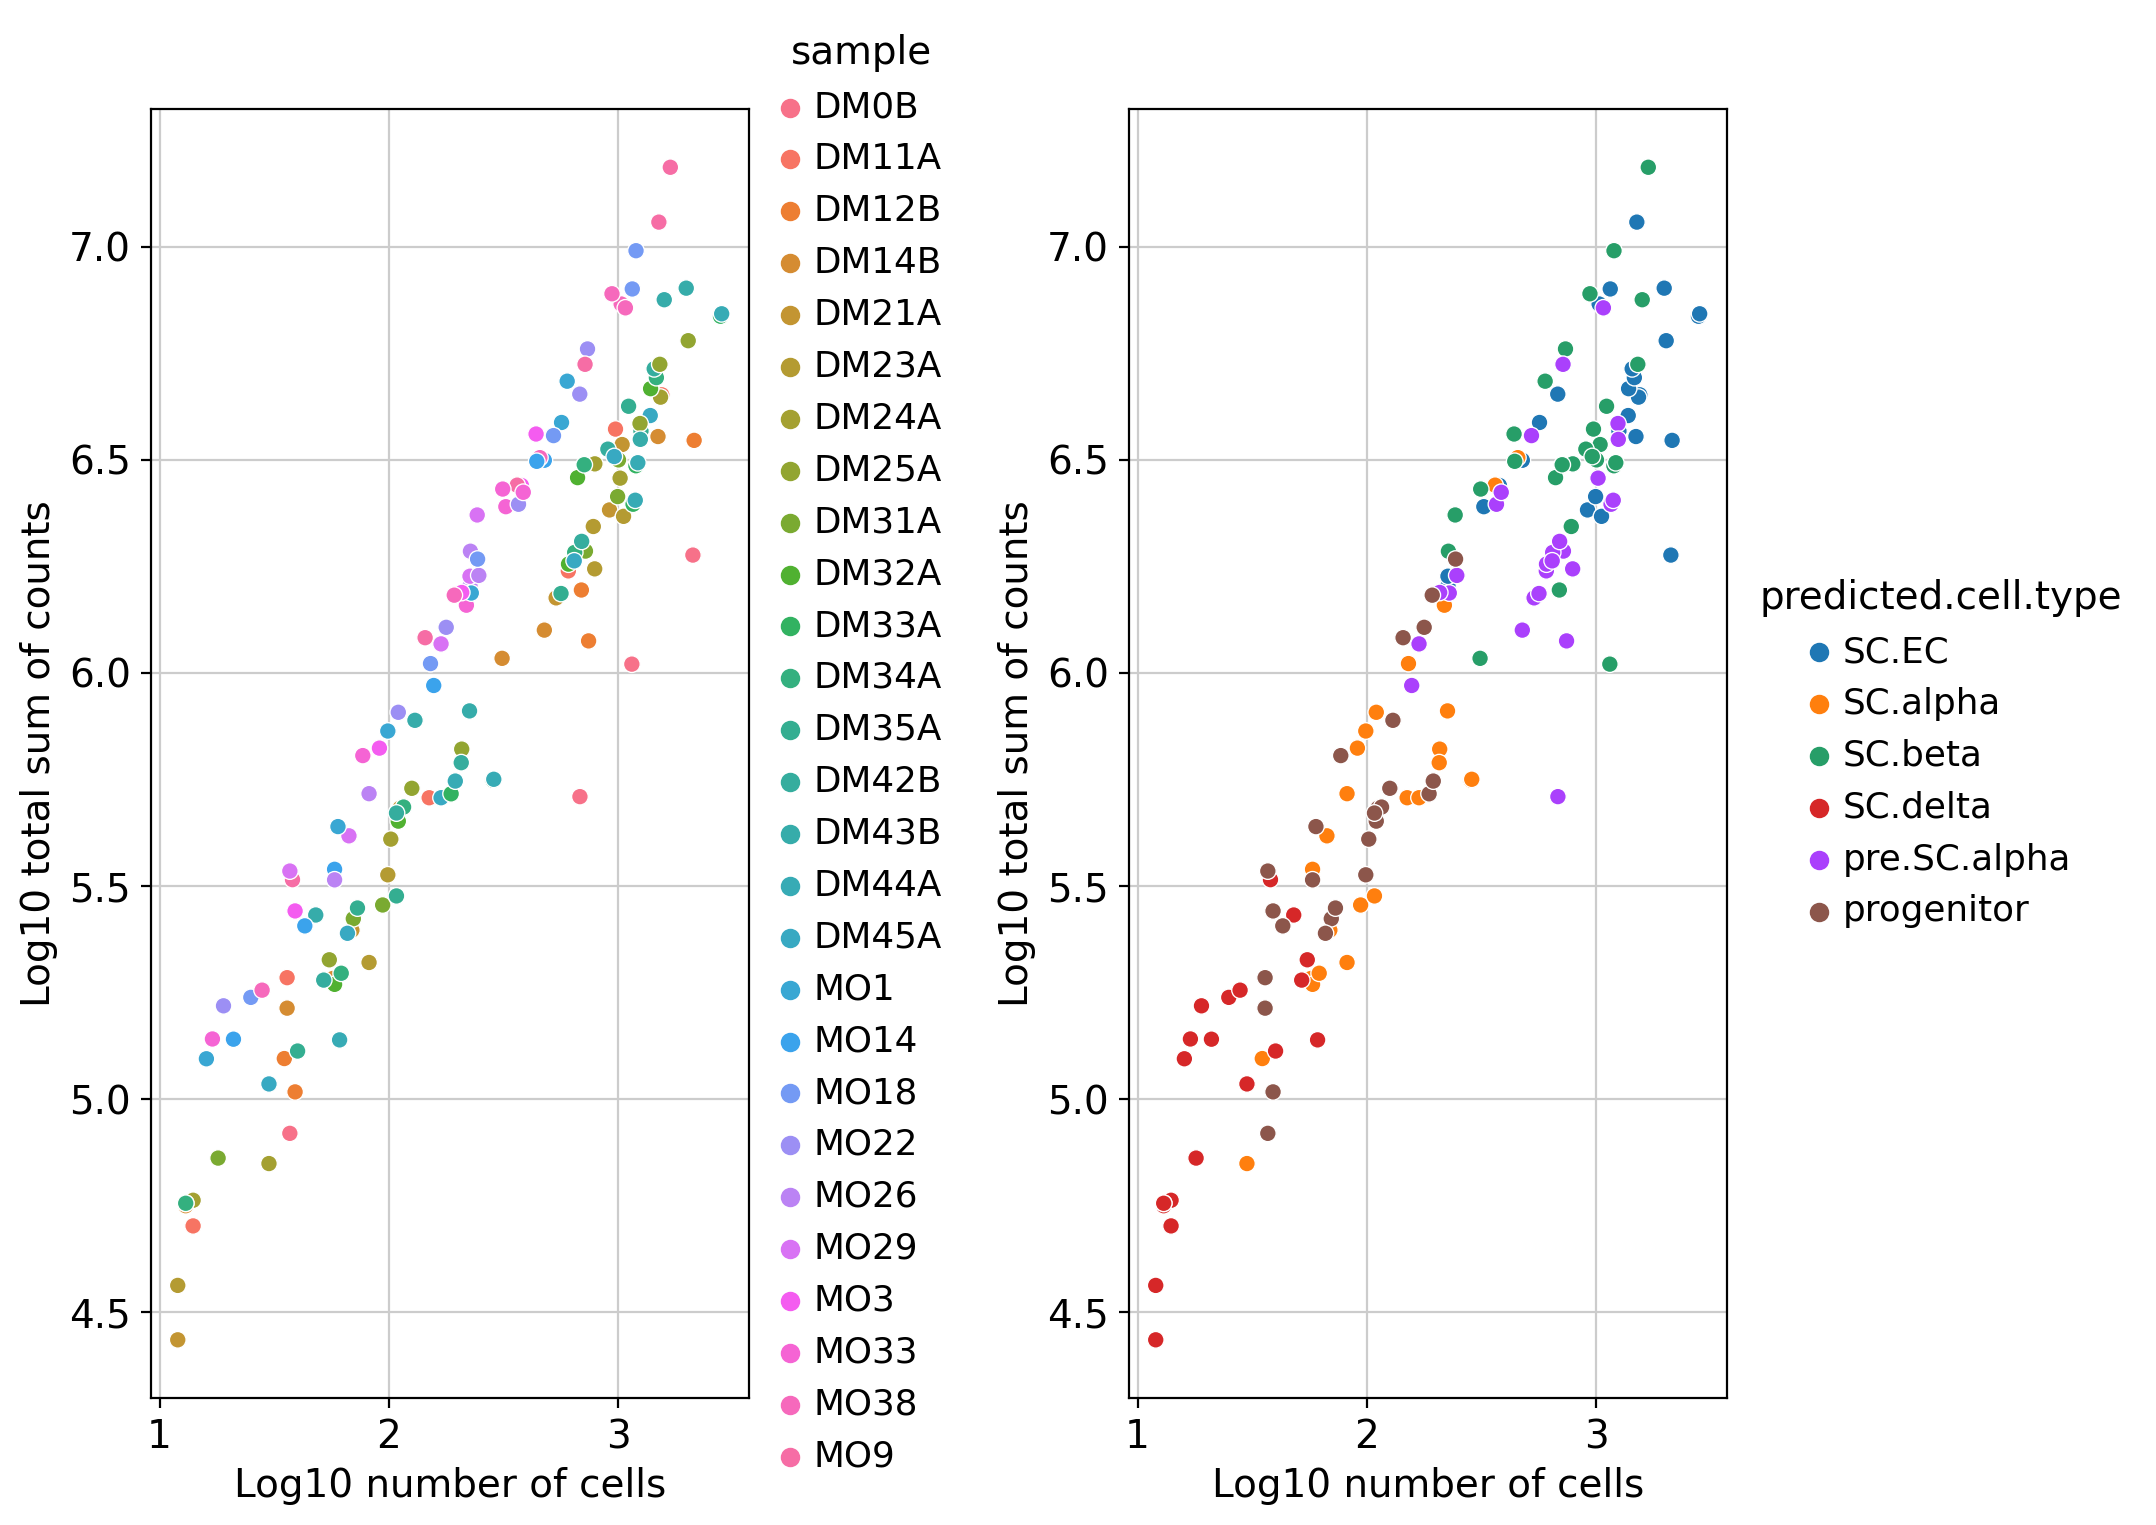

In [31]:
# Plot some QCs on the pseudo-bulk data
dc.plot_psbulk_samples(pdata, groupby=['sample', 'predicted.cell.type'], figsize=(11, 8), save=os.path.join(out_dir, "psbulk_filtered_samples_plot.png"))

In [32]:
# Save just the normal pseudo-bulk
pdata.obs["time_point"] = pdata.obs["time_point"].astype("category")
pdata.write(os.path.join(out_dir, "pseudobulk_h5ads", "pseudo_bulk_filter.h5ad"))

# Explore the pseudobulk profiles

## Preprocess the pseudobulk profiles

In [33]:
# Get a copy to process
pp_pdata = pdata.copy()

In [34]:
# Remove a problematic sample
pp_pdata = pp_pdata[~(pp_pdata.obs["sample"] == "DM0B")]

In [35]:
# CPM normalize
sc.pp.normalize_total(pp_pdata, target_sum=1e6)

normalizing counts per cell
    finished (0:00:00)


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [36]:
# log(1+p) transformation
sc.pp.log1p(pp_pdata)

In [37]:
# Scale
sc.pp.scale(pp_pdata, max_value=10)

## PCA

In [38]:
# PCA
sc.tl.pca(pp_pdata, n_comps=10)

computing PCA
    with n_comps=10
    finished (0:00:01)


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


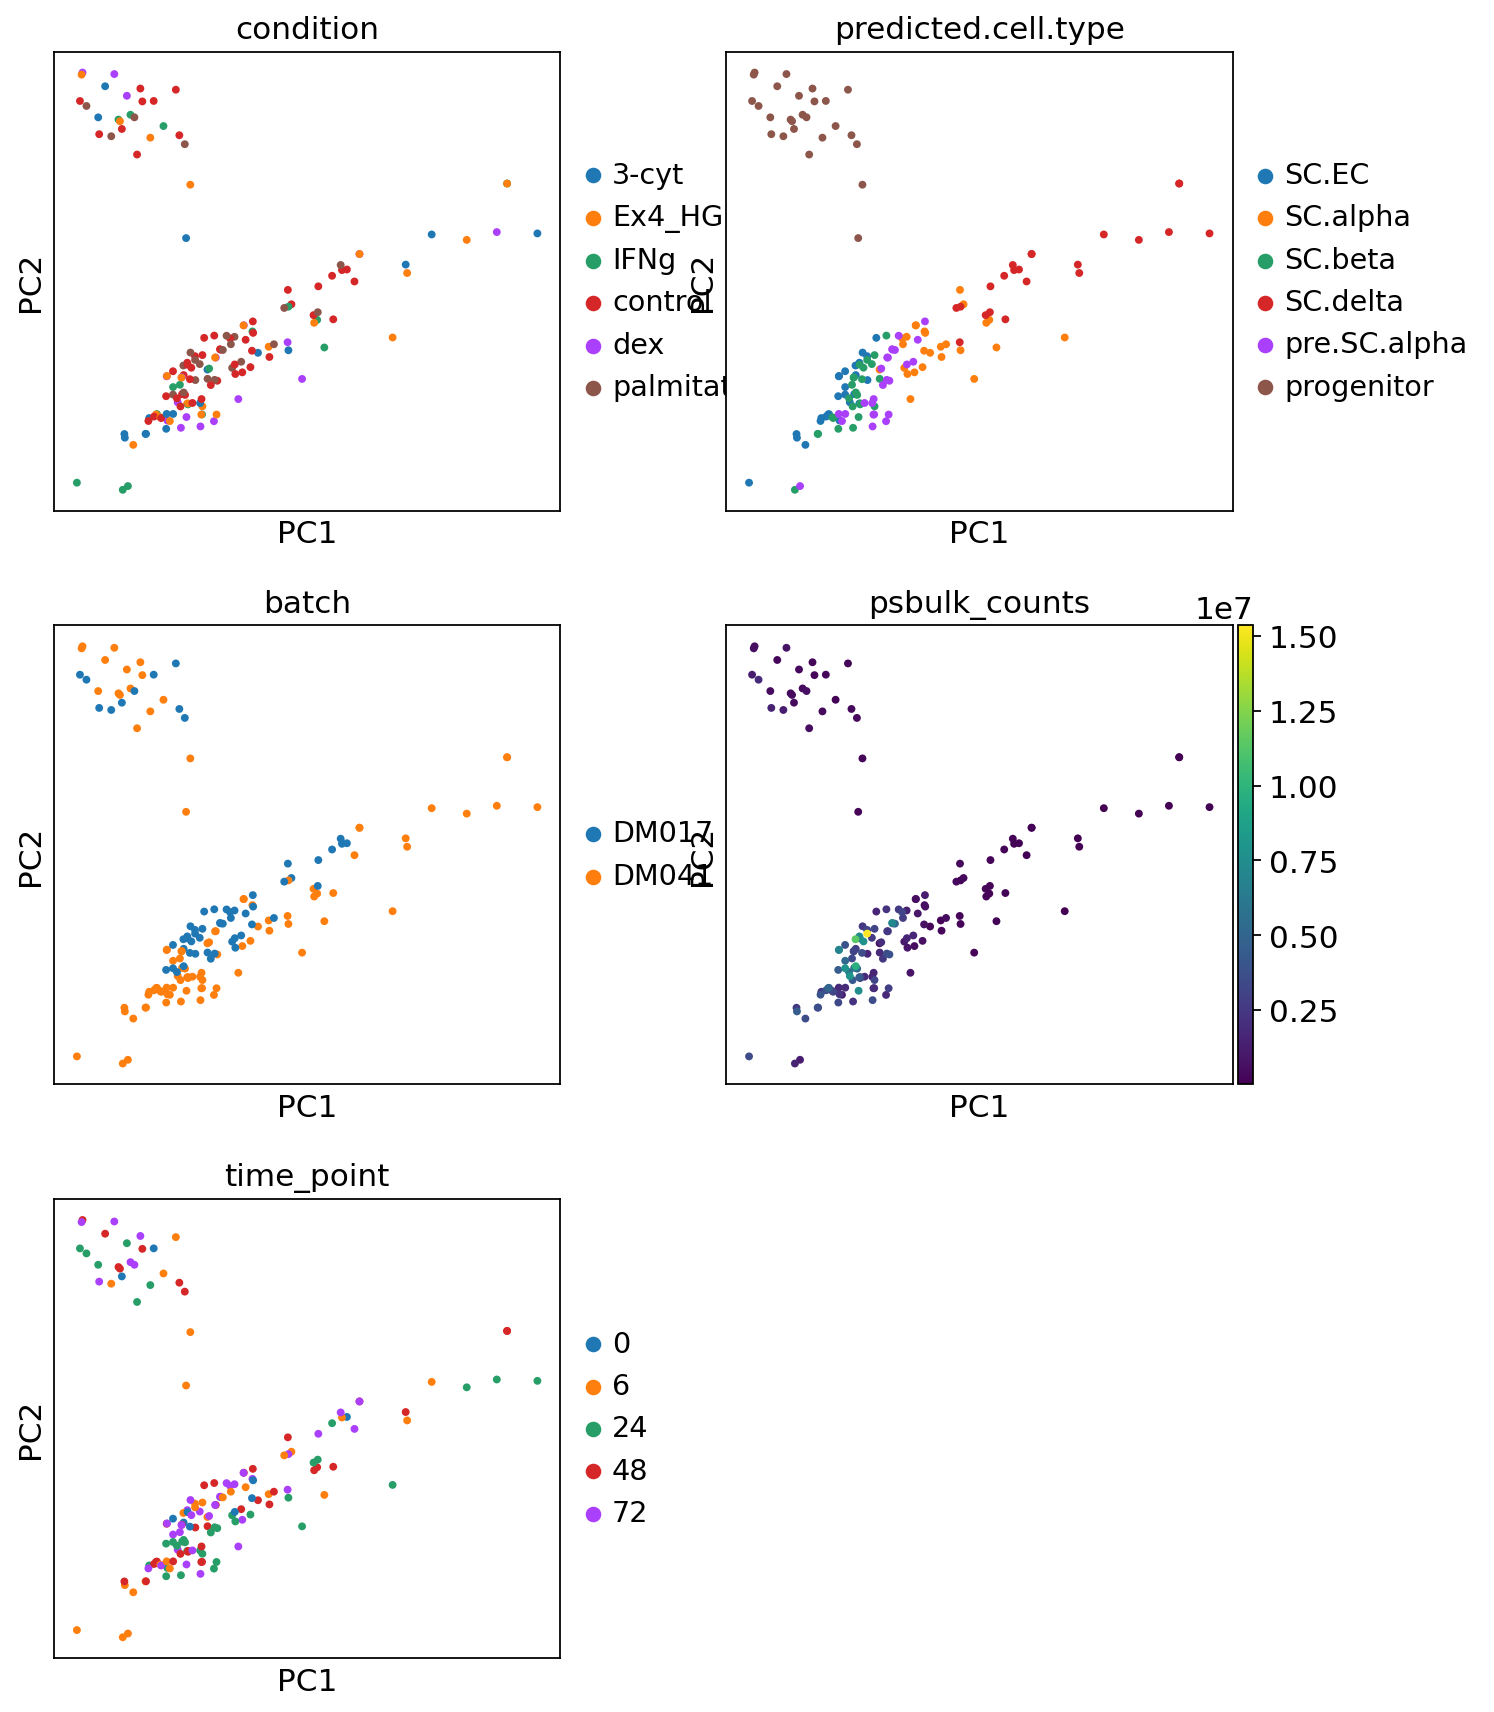

In [39]:
# Plot the PCA with covariates
with plt.rc_context():
    sc.pl.pca(pp_pdata, color=['condition', 'predicted.cell.type', 'batch', 'psbulk_counts', 'time_point'], ncols=2, size=50, show=False)
    plt.savefig(os.path.join(out_dir, "pca_w_covariates.png"))
    plt.show()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


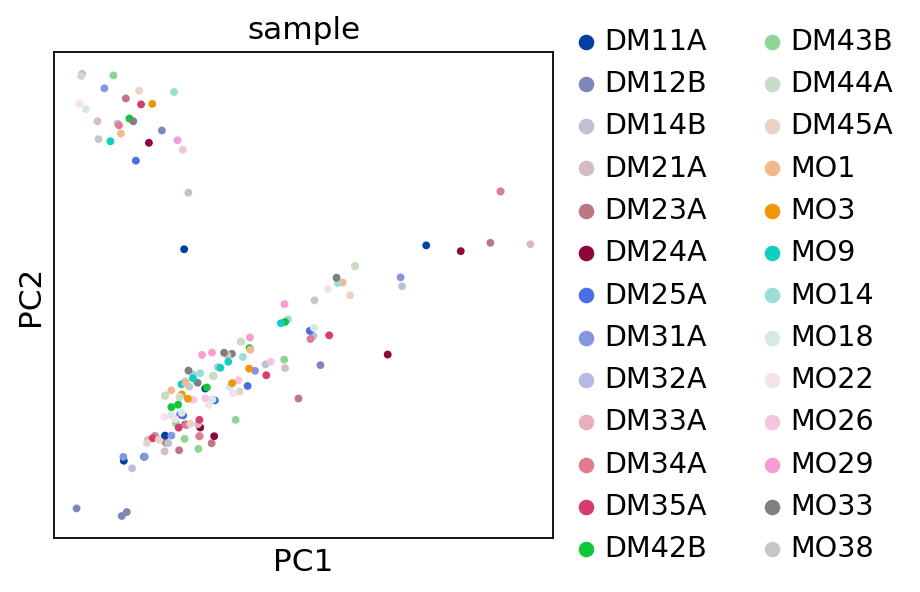

In [40]:
# Plot the PCA with sample
with plt.rc_context():
    sc.pl.pca(pp_pdata, color=['sample'], ncols=2, show=False, size=50)
    plt.savefig(os.path.join(out_dir, "pca_w_sample.png"))
    plt.show()

In [41]:
# Get correlations with PCs
pp_pdata.obs["predicted_cell_type"] = pp_pdata.obs["predicted.cell.type"].str.replace(".", "_")
dc.get_metadata_associations(
    pp_pdata,
    obs_keys = ['predicted_cell_type', 'batch', 'sample', 'condition', 'time_point', 'psbulk_n_cells', 'psbulk_counts'], #metadata columns to associate to PCs
    obsm_key='X_pca', #where the PCs are stored
    uns_key='pca_anova', #where the results are stored
    inplace=True
)

 10%|█         | 1/10 [00:00<00:02,  3.61it/s]

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations


Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


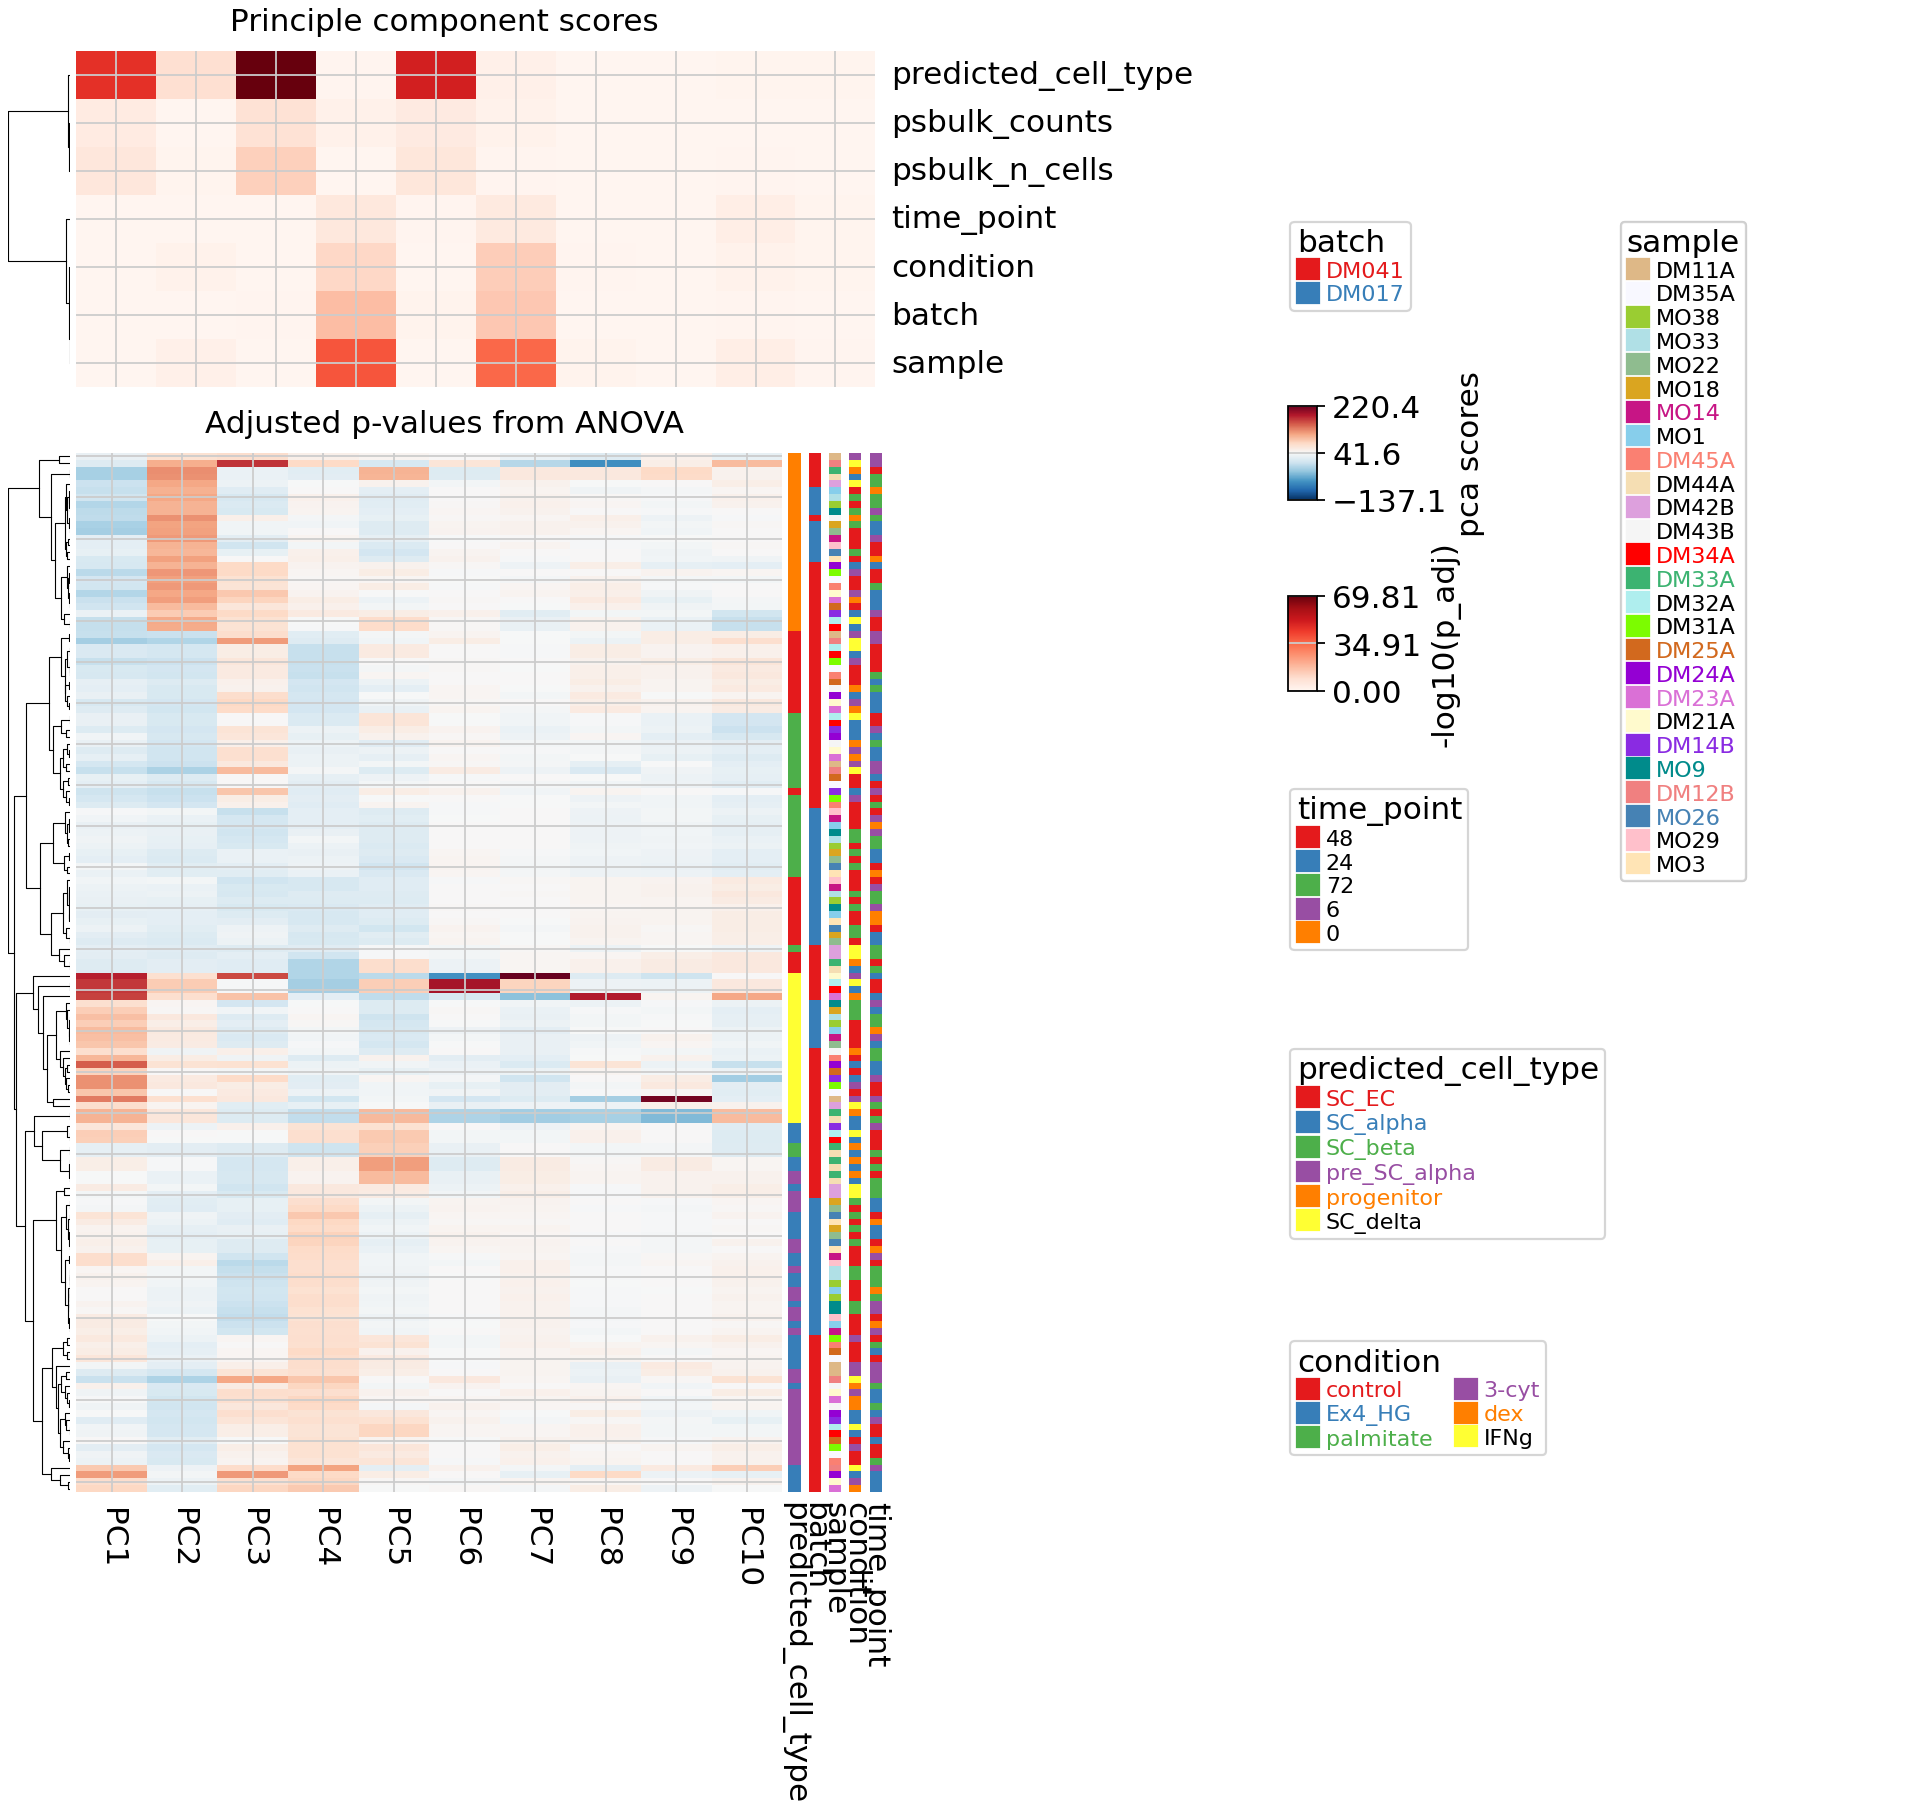

In [42]:
plt.figure(figsize=(7,10))
ax, legend_axes = dc.plot_associations(
    pp_pdata,
    uns_key='pca_anova', #summary statistics from the anova tests
    obsm_key='X_pca', #where the PCs are stored
    stat_col='p_adj', #which summary statistic to plot
    obs_annotation_cols = ['predicted_cell_type', 'batch', 'sample', 'condition', 'time_point'],
    titles=['Adjusted p-values from ANOVA', 'Principle component scores']) # which sample annotations to plot
plt.savefig(os.path.join(out_dir, "ps_pc_assocation_anova.png"), bbox_inches='tight')
plt.show()

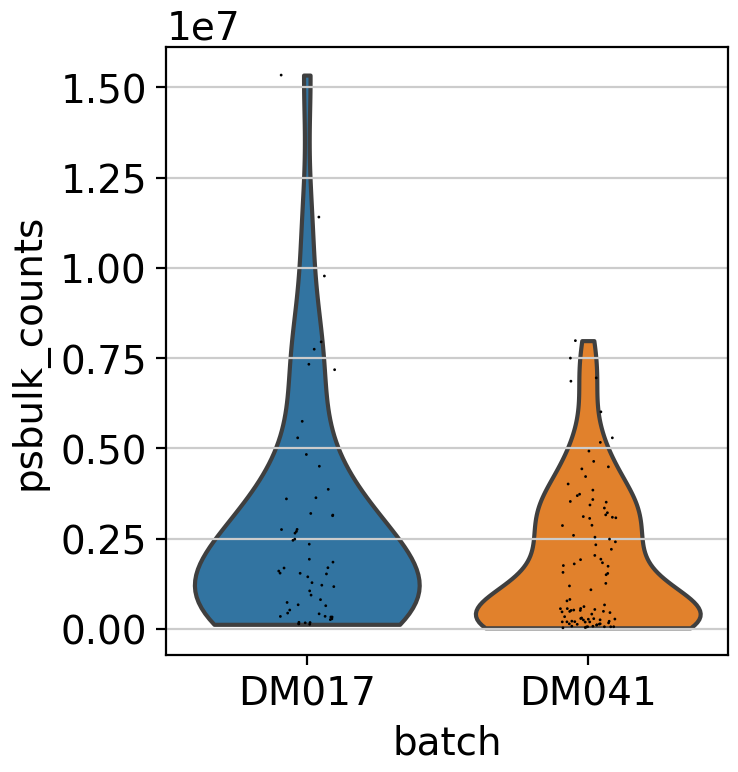

In [43]:
with plt.rc_context():
    sc.pl.violin(pp_pdata, keys="psbulk_counts", groupby="batch", show=False)
    plt.savefig(os.path.join(out_dir, "ps_counts_by_batch.png"), bbox_inches='tight')
    plt.show()

# Creating pseudobulk pdatas for DESeq2

In [44]:
# Get unique values for covariates of interest
cell_types = pdata.obs["predicted_cell_type"].unique()
batches = pdata.obs["batch"].unique()
conditions = pdata.obs["condition"].unique()

In [45]:
# Remove a problematic sample
pdata = pdata[~(pdata.obs["sample"] == "DM0B")]
pdata

View of AnnData object with n_obs × n_vars = 152 × 32246
    obs: 'orig.ident', 'batch', 'condition', 'time_point', 'sample', 'predicted.cell.type', 'predicted_cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'psbulk_props'

## Pseudobulks by cell type only
Allows for multivariate contrasts across all condition vs control within across batches

In [47]:
make_dirs(os.path.join(out_dir, "pseudobulk_h5ads", "predicted_cell_type"))

'/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome/25Aug23/pseudobulk_analysis/create_pseudobulks/2545199730_20230829-095741/pseudobulk_h5ads/pseudo_bulk_predicted_cell_type'

In [48]:
for cell_type in cell_types:
    cell_type_condition = pdata.obs['predicted_cell_type'] == cell_type

    # Select profiles of interest
    pdata_deseq = pdata[cell_type_condition, :].copy()
    pdata_deseq.obs["sample"] = pdata_deseq.obs["sample"].astype("category")

    # Obtain genes that pass the thresholds
    genes = dc.filter_by_expr(pdata_deseq, group='condition', min_count=10, min_total_count=15)

    # Filter by these genes
    pdata_deseq = pdata_deseq[:, genes].copy()

    # Print the number of genes and samples
    print(f"Cell type: {cell_type}")
    print(f"Genes: {pdata_deseq.n_vars}")
    print(f"Samples: {pdata_deseq.n_obs}")

    # Save the object
    pdata_deseq.write(os.path.join(out_dir, "pseudobulk_h5ads", "predicted_cell_type", f"pseudo_bulk_{cell_type}.h5ad"))

Cell type: SC_EC
Genes: 16711
Samples: 26
Cell type: SC_alpha
Genes: 9633
Samples: 26
Cell type: SC_beta
Genes: 15733
Samples: 26
Cell type: SC_delta
Genes: 5164
Samples: 22
Cell type: pre_SC_alpha
Genes: 13888
Samples: 26
Cell type: progenitor
Genes: 9924
Samples: 26


In [49]:
pdata.obs.value_counts("predicted_cell_type")

predicted_cell_type
SC_EC           26
SC_alpha        26
SC_beta         26
pre_SC_alpha    26
progenitor      26
SC_delta        22
dtype: int64

# Pseudobulks for each cell type separated into batch
Allows for multivariate contrasts across all condition vs control within only a batch

In [51]:
make_dirs(os.path.join(out_dir, "pseudobulk_h5ads", "predicted_cell_type_by_batch"))

'/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome/25Aug23/pseudobulk_analysis/create_pseudobulks/2545199730_20230829-095741/pseudobulk_h5ads/predicted_cell_type_by_batch'

In [52]:
for batch in batches:
    for cell_type in cell_types:
        batch_condition = pdata.obs['batch'] == batch
        cell_type_condition = pdata.obs['predicted_cell_type'] == cell_type

        # Select profiles of interest
        pdata_deseq = pdata[cell_type_condition & batch_condition, :].copy()
        pdata_deseq.obs["sample"] = pdata_deseq.obs["sample"].astype("category")

        # Obtain genes that pass the thresholds
        genes = dc.filter_by_expr(pdata_deseq, group='condition', min_count=10, min_total_count=15)

        # Filter by these genes
        pdata_deseq = pdata_deseq[:, genes].copy()

        # Print the number of genes and samples
        print(f"Cell type: {cell_type} | Batch: {batch}")
        print(f"Genes: {pdata_deseq.n_vars}")
        print(f"Samples: {pdata_deseq.n_obs}")

        # Save the object
        pdata_deseq.write(os.path.join(out_dir, "pseudobulk_h5ads", "predicted_cell_type_by_batch", f"pseudo_bulk_{cell_type}_{batch}.h5ad"))

Cell type: SC_EC | Batch: DM041
Genes: 16433
Samples: 16
Cell type: SC_alpha | Batch: DM041
Genes: 6847
Samples: 16
Cell type: SC_beta | Batch: DM041
Genes: 15300
Samples: 16
Cell type: SC_delta | Batch: DM041
Genes: 2888
Samples: 15
Cell type: pre_SC_alpha | Batch: DM041
Genes: 13517
Samples: 16
Cell type: progenitor | Batch: DM041
Genes: 9192
Samples: 16


Cell type: SC_EC | Batch: DM017
Genes: 14161
Samples: 10
Cell type: SC_alpha | Batch: DM017
Genes: 8946
Samples: 10
Cell type: SC_beta | Batch: DM017
Genes: 14625
Samples: 10
Cell type: SC_delta | Batch: DM017
Genes: 4060
Samples: 7
Cell type: pre_SC_alpha | Batch: DM017
Genes: 12271
Samples: 10
Cell type: progenitor | Batch: DM017
Genes: 8343
Samples: 10


In [53]:
pd.crosstab(pdata.obs["predicted_cell_type"], pdata.obs["batch"])

batch,DM017,DM041
predicted_cell_type,,
SC_EC,10,16
SC_alpha,10,16
SC_beta,10,16
SC_delta,7,15
pre_SC_alpha,10,16
progenitor,10,16


# Separate the cell types by condition
Allows for cross batch comparison, but keeps the DESeq2 model to a single bivariate contrast

In [54]:
make_dirs(os.path.join(out_dir, "pseudobulk_h5ads", "predicted_cell_type_by_condition"))

'/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome/25Aug23/pseudobulk_analysis/create_pseudobulks/2545199730_20230829-095741/pseudobulk_h5ads/predicted_cell_type_by_condition'

In [55]:
for condition in conditions:
    for cell_type in cell_types:
        
        # Don't want control only conditions
        if condition == "control":
            continue
        
        condition_condition = (pdata.obs['condition'] == condition) | (pdata.obs['condition'] == "control")
        cell_type_condition = pdata.obs['predicted_cell_type'] == cell_type
        
        # Select profiles of interest
        pdata_deseq = pdata[cell_type_condition & condition_condition, :].copy()
        pdata_deseq.obs["sample"] = pdata_deseq.obs["sample"].astype("category")

        # Obtain genes that pass the thresholds
        genes = dc.filter_by_expr(pdata_deseq, group='condition', min_count=10, min_total_count=15)

        # Filter by these genes
        pdata_deseq = pdata_deseq[:, genes].copy()

        # Print the number of genes and samples
        print(f"Cell type: {cell_type} | Condition: {condition}")
        print(f"Genes: {pdata_deseq.n_vars}")
        print(f"Samples: {pdata_deseq.n_obs}")

        # Save the object
        pdata_deseq.write(os.path.join(out_dir, "pseudobulk_h5ads", "predicted_cell_type_by_condition", f"pseudo_bulk_{cell_type}_{condition}.h5ad"))

Cell type: SC_EC | Condition: 3-cyt
Genes: 15343
Samples: 12
Cell type: SC_alpha | Condition: 3-cyt
Genes: 8414
Samples: 12
Cell type: SC_beta | Condition: 3-cyt
Genes: 15111
Samples: 12
Cell type: SC_delta | Condition: 3-cyt
Genes: 3667
Samples: 10
Cell type: pre_SC_alpha | Condition: 3-cyt
Genes: 12441
Samples: 12
Cell type: progenitor | Condition: 3-cyt
Genes: 7216
Samples: 12
Cell type: SC_EC | Condition: IFNg
Genes: 15394
Samples: 12
Cell type: SC_alpha | Condition: IFNg
Genes: 8622
Samples: 12
Cell type: SC_beta | Condition: IFNg
Genes: 14939
Samples: 12
Cell type: SC_delta | Condition: IFNg
Genes: 4213
Samples: 9
Cell type: pre_SC_alpha | Condition: IFNg
Genes: 12485
Samples: 12
Cell type: progenitor | Condition: IFNg
Genes: 8137
Samples: 12
Cell type: SC_EC | Condition: Ex4_HG
Genes: 15105
Samples: 13
Cell type: SC_alpha | Condition: Ex4_HG
Genes: 8104
Samples: 13
Cell type: SC_beta | Condition: Ex4_HG
Genes: 14372
Samples: 13
Cell type: SC_delta | Condition: Ex4_HG
Genes: 3428

Cell type: pre_SC_alpha | Condition: Ex4_HG
Genes: 12498
Samples: 13
Cell type: progenitor | Condition: Ex4_HG
Genes: 7944
Samples: 13
Cell type: SC_EC | Condition: dex
Genes: 15262
Samples: 12
Cell type: SC_alpha | Condition: dex
Genes: 9041
Samples: 12
Cell type: SC_beta | Condition: dex
Genes: 15297
Samples: 12
Cell type: SC_delta | Condition: dex
Genes: 3846
Samples: 10
Cell type: pre_SC_alpha | Condition: dex
Genes: 12605
Samples: 12
Cell type: progenitor | Condition: dex
Genes: 7978
Samples: 12
Cell type: SC_EC | Condition: palmitate
Genes: 14770
Samples: 13
Cell type: SC_alpha | Condition: palmitate
Genes: 8813
Samples: 13
Cell type: SC_beta | Condition: palmitate
Genes: 15064
Samples: 13
Cell type: SC_delta | Condition: palmitate
Genes: 4095
Samples: 10
Cell type: pre_SC_alpha | Condition: palmitate
Genes: 12209
Samples: 13
Cell type: progenitor | Condition: palmitate
Genes: 8055
Samples: 13


In [46]:
pd.crosstab(pdata.obs["predicted_cell_type"], pdata.obs["condition"])

condition,3-cyt,Ex4_HG,IFNg,control,dex,palmitate
predicted_cell_type,,,,,,
SC_EC,3,4,3,9,3,4
SC_alpha,3,4,3,9,3,4
SC_beta,3,4,3,9,3,4
SC_delta,3,4,2,7,3,3
pre_SC_alpha,3,4,3,9,3,4
progenitor,3,4,3,9,3,4


# Separate into cell types, batches and single conditions 
Allows for only within batch comparisons, and keeps the DESeq2 model to a single bivariate contrast. Note that some batches only have one condition or another, so this will not be possible for all batches.

In [56]:
make_dirs(os.path.join(out_dir, "pseudobulk_h5ads", "predicted_cell_type_by_batch-condition"))

'/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome/25Aug23/pseudobulk_analysis/create_pseudobulks/2545199730_20230829-095741/pseudobulk_h5ads/predicted_cell_type_by_batch-condition'

In [57]:
for condition in conditions:
    for batch in batches:
        for cell_type in cell_types:

            # Don't want control only conditions
            if condition == "control":
                continue
            
            # Get masks
            condition_condition = (pdata.obs['condition'] == condition) | (pdata.obs['condition'] == "control")
            batch_condition = pdata.obs['batch'] == batch
            cell_type_condition = pdata.obs['predicted_cell_type'] == cell_type

            # Select profiles of interest
            pdata_deseq = pdata[cell_type_condition & batch_condition & condition_condition, :].copy()
            pdata_deseq.obs["sample"] = pdata_deseq.obs["sample"].astype("category")

            # If the condition is not present in the cell type, skip
            if condition not in pdata_deseq.obs["condition"].unique():
                print(f"Cell type: {cell_type} | Batch: {batch} | Condition: {condition} | Not present")
                continue

            # Obtain genes that pass the thresholds
            genes = dc.filter_by_expr(pdata_deseq, group='condition', min_count=10, min_total_count=15)

            # Filter by these genes
            pdata_deseq = pdata_deseq[:, genes].copy()

            # Print the number of genes and samples
            print(f"Cell type: {cell_type} | Batch: {batch} | Condition: {condition}")
            print(f"Genes: {pdata_deseq.n_vars}")
            print(f"Samples: {pdata_deseq.n_obs}")

            # Save the object
            pdata_deseq.write(os.path.join(out_dir, "pseudobulk_h5ads", "predicted_cell_type_by_batch-condition", f"pseudo_bulk_{cell_type}_{batch}_{condition}.h5ad"))

Cell type: SC_EC | Batch: DM041 | Condition: 3-cyt
Genes: 14536
Samples: 6
Cell type: SC_alpha | Batch: DM041 | Condition: 3-cyt
Genes: 6627
Samples: 6
Cell type: SC_beta | Batch: DM041 | Condition: 3-cyt
Genes: 14362
Samples: 6
Cell type: SC_delta | Batch: DM041 | Condition: 3-cyt
Genes: 2247
Samples: 6
Cell type: pre_SC_alpha | Batch: DM041 | Condition: 3-cyt
Genes: 12049
Samples: 6
Cell type: progenitor | Batch: DM041 | Condition: 3-cyt
Genes: 5803
Samples: 6
Cell type: SC_EC | Batch: DM017 | Condition: 3-cyt | Not present
Cell type: SC_alpha | Batch: DM017 | Condition: 3-cyt | Not present
Cell type: SC_beta | Batch: DM017 | Condition: 3-cyt | Not present
Cell type: SC_delta | Batch: DM017 | Condition: 3-cyt | Not present
Cell type: pre_SC_alpha | Batch: DM017 | Condition: 3-cyt | Not present
Cell type: progenitor | Batch: DM017 | Condition: 3-cyt | Not present
Cell type: SC_EC | Batch: DM041 | Condition: IFNg
Genes: 14863
Samples: 6
Cell type: SC_alpha | Batch: DM041 | Condition: I

Cell type: pre_SC_alpha | Batch: DM041 | Condition: IFNg
Genes: 11957
Samples: 6
Cell type: progenitor | Batch: DM041 | Condition: IFNg
Genes: 6950
Samples: 6
Cell type: SC_EC | Batch: DM017 | Condition: IFNg | Not present
Cell type: SC_alpha | Batch: DM017 | Condition: IFNg | Not present
Cell type: SC_beta | Batch: DM017 | Condition: IFNg | Not present
Cell type: SC_delta | Batch: DM017 | Condition: IFNg | Not present
Cell type: pre_SC_alpha | Batch: DM017 | Condition: IFNg | Not present
Cell type: progenitor | Batch: DM017 | Condition: IFNg | Not present
Cell type: SC_EC | Batch: DM041 | Condition: Ex4_HG
Genes: 14970
Samples: 7
Cell type: SC_alpha | Batch: DM041 | Condition: Ex4_HG
Genes: 5759
Samples: 7
Cell type: SC_beta | Batch: DM041 | Condition: Ex4_HG
Genes: 13983
Samples: 7
Cell type: SC_delta | Batch: DM041 | Condition: Ex4_HG
Genes: 2808
Samples: 7
Cell type: pre_SC_alpha | Batch: DM041 | Condition: Ex4_HG
Genes: 12389
Samples: 7
Cell type: progenitor | Batch: DM041 | Condi

In [58]:
for cell_type in cell_types:
    curr_pdata = pdata[pdata.obs["predicted_cell_type"] == cell_type, :].copy()
    print(pd.crosstab(curr_pdata.obs["batch"], curr_pdata.obs["condition"]))

condition  3-cyt  Ex4_HG  IFNg  control  dex  palmitate
batch                                                  
DM017          0       0     0        6    0          4
DM041          3       4     3        3    3          0
condition  3-cyt  Ex4_HG  IFNg  control  dex  palmitate
batch                                                  
DM017          0       0     0        6    0          4
DM041          3       4     3        3    3          0
condition  3-cyt  Ex4_HG  IFNg  control  dex  palmitate
batch                                                  
DM017          0       0     0        6    0          4
DM041          3       4     3        3    3          0
condition  3-cyt  Ex4_HG  IFNg  control  dex  palmitate
batch                                                  
DM017          0       0     0        4    0          3
DM041          3       4     2        3    3          0
condition  3-cyt  Ex4_HG  IFNg  control  dex  palmitate
batch                                           

# DONE!

---